# Phishing Email Detector

## Setup

In [1]:
from pathlib import Path
import re
import os
import random
import math
from collections import Counter


import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urlextract import URLExtract
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler

from utils import EmailDataset, tokenize, build_vocab, preprocess_text

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Config
DATA_PROCESSED = Path("data/preprocessed")  # path
FILEPATH_DATA_PREPROCESSED = DATA_PROCESSED / "preprocessed_data.csv"  # filename
DATA_ALREADY_PREPROCESSED = True  # whether the data is already preprocessed

MAX_VOCAB = 40000
MAX_LEN = 256
EMBED_DIM = 128
HIDDEN_DIM = 128
BATCH_SIZE = 64
EPOCHS = 6
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


[nltk_data] Downloading package punkt_tab to /home/enrico/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load the Dataset

Looking for dataset at: data/preprocessed/preprocessed_data.csv
                                                text  label  n_upper  \
0  re : 6 . 1100 , disc : uniformitarianism , re ...      0        0   
1  the other side of * galicismos * * galicismo *...      0        0   
2  re : equistar deal tickets are you still avail...      0        0   
3  hello i am your hot lil horny toy. i am the on...      1       39   
4  software at incredibly low prices ( 86 % lower...      1        0   

   n_exclaim  n_special  length  has_login_words  n_urls  \
0          2         61     230                0       0   
1          0         18      91                0       0   
2          0         96     305                0       0   
3          1        112      96                0       2   
4          0         27      91                0       0   

                                             urls  \
0                                              []   
1                                   

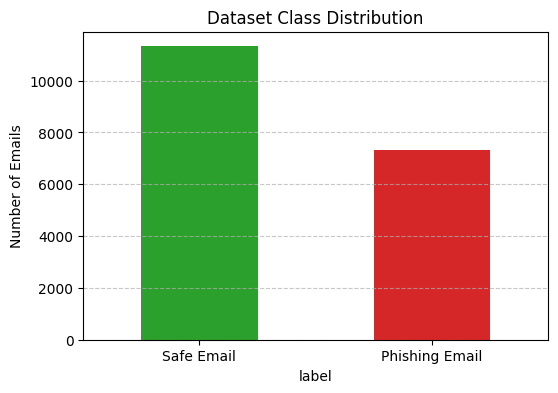

In [2]:
print(f"Looking for dataset at: {FILEPATH_DATA_PREPROCESSED}")

assert os.path.exists(FILEPATH_DATA_PREPROCESSED), f"Dataset not found: {FILEPATH_DATA_PREPROCESSED}"
df = pd.read_csv(FILEPATH_DATA_PREPROCESSED)

df.columns = [c.strip() for c in df.columns] # clean column names
print(df.head())

# Show dataset size and label distribution
print("\nDataset size:", len(df))
print(df['label'].value_counts())


# Class distribution plot
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', color=['#2ca02c', '#d62728'])
plt.xticks(ticks=[0,1], labels=['Safe Email', 'Phishing Email'], rotation=0)
plt.title('Dataset Class Distribution')
plt.ylabel('Number of Emails')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Model

In [3]:
class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.proj = nn.Linear(dim, 1)


    def forward(self, x, mask=None):
        # x: batch x seq x dim
        scores = self.proj(x).squeeze(-1) # batch x seq
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1).unsqueeze(-1) # batch x seq x 1
        out = (x * attn).sum(dim=1) # batch x dim
        return out, attn


class PhishingDetectorModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_feats_dim=6, num_classes=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.att = Attention(hidden_dim * 2)
        self.fc_text = nn.Linear(hidden_dim * 2, 128)
        self.fc_comb = nn.Linear(128 + num_feats_dim, 64)
        self.out = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout)


    def forward(self, seq, lengths, num_feats):
        emb = self.embedding(seq)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        mask = (seq != 0).to(seq.device)
        attn_out, attn_weights = self.att(out, mask)
        x = F.relu(self.fc_text(attn_out))
        x = self.dropout(x)
        x = torch.cat([x, num_feats], dim=1)
        x = F.relu(self.fc_comb(x))
        x = self.dropout(x)
        logits = self.out(x)
        return logits, attn_weights

## Training and Evaluation

In [ ]:
def compute_metrics(y_true, y_pred_probs, threshold=0.5):
    y_pred = (y_pred_probs[:, 1] >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(y_true, y_pred_probs[:, 1])
    except Exception:
        auc = float("nan")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1, "roc_auc": auc}


def train_one_epoch(model, dataloader, opt, criterion):
    model.train()
    losses = []
    for batch in tqdm(dataloader, desc="train step"):
        seq = batch["seq"].to(DEVICE)
        lengths = batch["lengths"].to(DEVICE)
        num = batch["num"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        opt.zero_grad()
        logits, _ = model(seq, lengths, num)
        loss = criterion(logits, labels)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)


def eval_model(model, dataloader):
    model.eval()
    probs = []
    trues = []
    with torch.no_grad():
        for batch in dataloader:
            seq = batch["seq"].to(DEVICE)
            lengths = batch["lengths"].to(DEVICE)
            num = batch["num"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            logits, attn = model(seq, lengths, num)
            p = torch.softmax(logits, dim=1).cpu().numpy()
            probs.append(p)
            trues.append(labels.cpu().numpy())
    probs = np.vstack(probs)
    trues = np.concatenate(trues)
    return trues, probs


# Get computed features from file
TODO

# Split: test, val and train sets
train_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1, stratify=train_df["label"], random_state=SEED
)

print(
    f"Train size: {len(train_df)}\nVal size: {len(val_df)}\nTest size: {len(test_df)}"
)

  0%|          | 0/18650 [00:00<?, ?it/s]

Train size: 14266
Val size: 1586
Test size: 2798


In [5]:
# Print sample line
print("Sample text, tokenized, label:")
print(df['text'].iloc[0])
print(token_lists[0])
print(df['label'].iloc[0])

Sample text, tokenized, label:
re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to " sons " being " treated like senior relatives " . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps 

## Main Training Loop

In [6]:

# Build vocab on train only
train_token_lists = [token_lists[i] for i in train_df.index]
stoi, itos = build_vocab(train_token_lists, max_vocab=MAX_VOCAB)
vocab_size = len(stoi)
print("Vocab size:", vocab_size)


# Fit scaler on train
train_ds_tmp = EmailDataset(train_df, stoi, MAX_LEN, scaler=None, already_preprocessed=DATA_ALREADY_PREPROCESSED)
scaler = StandardScaler().fit(train_ds_tmp.num_feats)
print("Scaler mean:", scaler.mean_)
print("Scaler var:", scaler.var_)

# Create datasets
train_ds = EmailDataset(train_df, stoi, MAX_LEN, scaler=scaler, already_preprocessed=DATA_ALREADY_PREPROCESSED)
val_ds = EmailDataset(val_df, stoi, MAX_LEN, scaler=scaler, already_preprocessed=DATA_ALREADY_PREPROCESSED)
test_ds = EmailDataset(test_df, stoi, MAX_LEN, scaler=scaler, already_preprocessed=DATA_ALREADY_PREPROCESSED)

print(f"Number of features: {train_ds.num_feats.shape[1]}")

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

print(f"Number of training batches: {len(train_loader)}")

# Weighted loss for imbalance
label_counts = train_df["label"].value_counts().sort_index()
total = label_counts.sum()
weights = [total / (2 * c) for c in label_counts]
class_weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)


# Model, loss, optimizer
model = PhishingDetectorModel(
    vocab_size=vocab_size,
    emb_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_feats_dim=train_ds.num_feats.shape[1],
)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
opt = torch.optim.Adam(model.parameters(), lr=LR)

print("Starting training...")

# Training loop
best_val_f1 = -1

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # tqdm for batch progress
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False)
    for batch in progress_bar:
        inputs, num_feats, labels = [x.to(DEVICE) for x in batch]

        opt.zero_grad()
        outputs = model(inputs, num_feats)
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)

    # Validation phase
    trues_val, probs_val = eval_model(model, val_loader)
    val_metrics = compute_metrics(trues_val, probs_val)

    print(f"Train loss: {train_loss:.4f} | Val metrics: {val_metrics}")

    # Save best model
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        torch.save(
            {
                "model_state": model.state_dict(),
                "stoi": stoi,
                "itos": itos,
                "scaler": scaler,
            },
            "best_phish_model.pth",
        )
        print("✅ Saved best model (F1 improved).")

Vocab size: 40002
Scaler mean: [2.15196972e-02 6.47189121e+00 2.67089584e+00 1.94221015e+02
 5.89075144e+02 1.97322305e-01]
Scaler var: [5.19223282e+00 4.31954011e+03 1.45176571e+04 1.01370416e+08
 8.72366275e+08 1.58386213e-01]


KeyboardInterrupt: 

## Evaluation

In [ ]:
ckpt = torch.load("best_phish_model.pth", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
trues_test, probs_test = eval_model(model, test_loader)
test_metrics = compute_metrics(trues_test, probs_test)
print("Final test metrics:", test_metrics)

## Inference

In [ ]:
def load_artifacts(filepath="best_phish_model.pth"):
    ckpt = torch.load(filepath, map_location=DEVICE)
    model = PhishingDetectorModel(
        vocab_size=len(ckpt["stoi"]),
        emb_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        num_feats_dim=6,
    )
    model.load_state_dict(ckpt["model_state"])
    model.to(DEVICE)
    model.eval()
    return model, ckpt["stoi"], ckpt["scaler"]


def preprocess_single(body, stoi, scaler, max_len=MAX_LEN):
    text = preprocess_text(body)
    toks = tokenize(text)
    ids = [stoi.get(tok, stoi.get("<UNK>")) for tok in toks][:max_len]

    # numeric features
    n_upper = sum(1 for c in raw if c.isupper())
    n_exclaim = raw.count("!")
    n_special = sum(1 for c in raw if not c.isalnum() and not c.isspace())
    length = len(text.split())
    has_login_words = int(bool(KEYWORD_PATTERN.search(text)))
    feats = np.array(
        [[n_urls, n_upper, n_exclaim, n_special, length, has_login_words]],
        dtype=np.float32,
    )
    feats = scaler.transform(feats)

    seq = torch.tensor([ids], dtype=torch.long).to(DEVICE)
    lengths = torch.tensor([len(ids)], dtype=torch.long).to(DEVICE)
    num = torch.tensor(feats, dtype=torch.float).to(DEVICE)
    return seq, lengths, num


def predict_email(body, model, stoi, scaler, threshold=0.5):
    seq, lengths, num = preprocess_single(body, stoi, scaler)
    with torch.no_grad():
        logits, attn = model(seq, lengths, num)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    label = int(probs[1] >= threshold)
    return {
        "prob_safe": float(probs[0]),
        "prob_phish": float(probs[1]),
        "label": label,
        "attn_weights": attn.cpu().numpy() if attn is not None else None,
    }